In [11]:
!pip -q install -U scikit-learn joblib


In [12]:
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
from google.colab import files

# If you uploaded a CSV, put its exact file name here, e.g. '/content/StudentPerformance.csv'
# CSV_PATH = ""  # leave empty to generate synthetic data

# Ask the user to upload the CSV file
uploaded = files.upload()

# Get the name of the uploaded file
CSV_PATH = next(iter(uploaded))


# If your CSV has different column names, change these after checking df.columns
STUDY_COL_CANDIDATES  = ["study_hours", "StudyHours", "HoursStudied", "Study_Hours"]
SCORE_COL_CANDIDATES  = ["final_score", "FinalScore", "ExamScore", "Score", "Exam_Score"]

Saving StudentPerformanceFactors.csv to StudentPerformanceFactors (1).csv


In [13]:
def load_or_generate(csv_path=""):
    if csv_path and os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    else:
        # synthetic fallback so you can run end-to-end immediately
        rng = np.random.default_rng(42)
        n = 400
        study_hours = rng.uniform(0, 10, n)
        attendance  = rng.normal(0.9, 0.07, n).clip(0.5, 1.0)
        sleep_hours = rng.normal(7.0, 1.0, n).clip(4, 10)
        noise = rng.normal(0, 5, n)
        base = 8 * np.minimum(study_hours, 7) + 4 * np.maximum(study_hours - 7, 0)
        final_score = np.clip(60 + base + 10*(attendance-0.8) + 2*(sleep_hours-7) + noise, 0, 100)
        df = pd.DataFrame({
            "study_hours": study_hours,
            "attendance": attendance,
            "sleep_hours": sleep_hours,
            "final_score": final_score
        })
    return df

df_raw = load_or_generate(CSV_PATH)
print("Columns:", list(df_raw.columns))
df_raw.head(10)


Columns: ['Hours_Studied', 'Attendance', 'Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours', 'Previous_Scores', 'Motivation_Level', 'Internet_Access', 'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender', 'Exam_Score']


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70
5,19,88,Medium,Medium,Yes,8,89,Medium,Yes,3,Medium,Medium,Public,Positive,3,No,Postgraduate,Near,Male,71
6,29,84,Medium,Low,Yes,7,68,Low,Yes,1,Low,Medium,Private,Neutral,2,No,High School,Moderate,Male,67
7,25,78,Low,High,Yes,6,50,Medium,Yes,1,High,High,Public,Negative,2,No,High School,Far,Male,66
8,17,94,Medium,High,No,6,80,High,Yes,0,Medium,Low,Private,Neutral,1,No,College,Near,Male,69
9,23,98,Medium,Medium,Yes,8,71,Medium,Yes,0,High,High,Public,Positive,5,No,High School,Moderate,Male,72


In [14]:
def find_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

study_col = find_col(df_raw, STUDY_COL_CANDIDATES)
score_col = find_col(df_raw, SCORE_COL_CANDIDATES)

# If not auto-detected, set them manually like:
study_col = "Hours_Studied"
# score_col = "Score"

assert study_col is not None, "Set study_col to your study-hours column name."
assert score_col is not None, "Set score_col to your final-score column name."

df = df_raw[[study_col, score_col]].rename(columns={study_col: "study_hours", score_col: "final_score"})
# Clean up: remove NaNs/outliers
df = df.replace([np.inf, -np.inf], np.nan).dropna()
df = df[(df["study_hours"] >= 0) & (df["study_hours"] <= 24)]
df = df[(df["final_score"] >= 0) & (df["final_score"] <= 100)].copy()

df.describe()

,study_hours,final_score
count,5145.000000,5145.000000
mean,17.687464,66.548105
std,4.476078,3.656476
min,1.000000,55.000000
25%,15.000000,64.000000
50%,18.000000,66.000000
75%,21.000000,69.000000
max,24.000000,100.000000


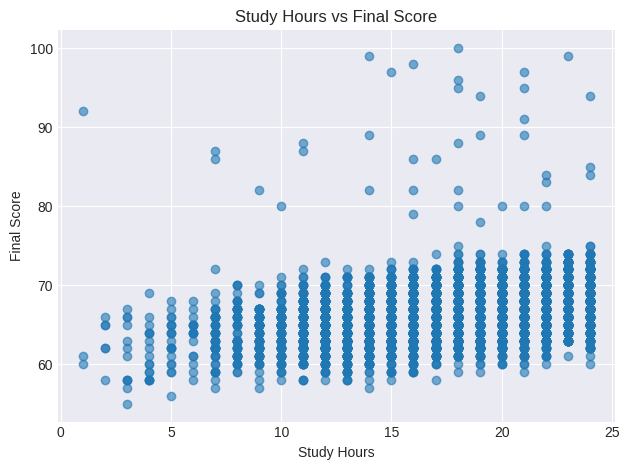

In [15]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure()
plt.scatter(df["study_hours"], df["final_score"], alpha=0.6)
plt.xlabel("Study Hours")
plt.ylabel("Final Score")
plt.title("Study Hours vs Final Score")
plt.tight_layout()
plt.show()

In [16]:
# Select features (X) and target (y)
# You can experiment with different feature combinations by uncommenting and adding column names
feature_cols = [study_col]
feature_cols = [study_col, "Sleep_Hours"]
feature_cols = [study_col, "Attendance", "Sleep_Hours"]

X = df_raw[feature_cols].values
y = df_raw[score_col].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
len(X_train), len(X_test)

(5285, 1322)

In [17]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
r2   = r2_score(y_test, y_pred)

print("Linear Regression metrics")
print(f"MAE  : {mae:.3f}")
print(f"MSE  : {mse:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R^2  : {r2:.3f}")
print("Intercept:", lin_reg.intercept_, "| Coef (per study hour):", lin_reg.coef_[0])


Linear Regression metrics
MAE  : 1.471
MSE  : 5.818
RMSE : 2.412
R^2  : 0.588
Intercept: 45.937048965691304 | Coef (per study hour): 0.2891956981390525


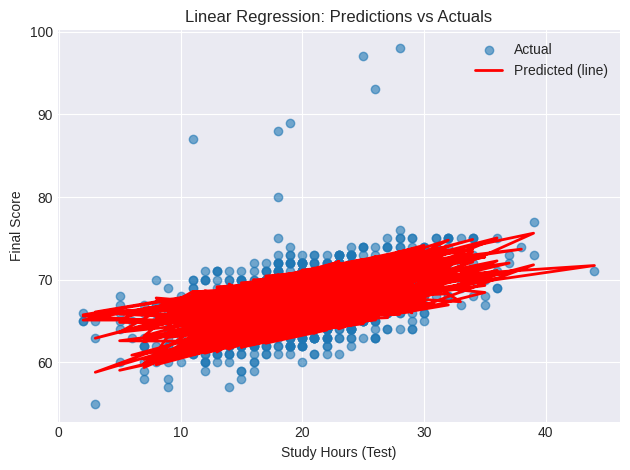

In [23]:
# Assign test sets and predictions to variables for plotting
X_s = X_test
y_s = y_test
yhat_s = y_pred

plt.figure()
plt.scatter(X_s[:, 0], y_s, alpha=0.6, label="Actual")
plt.plot(X_s[:, 0], yhat_s, color="red", linewidth=2, label="Predicted (line)")
plt.xlabel("Study Hours (Test)")
plt.ylabel("Final Score")
plt.title("Linear Regression: Predictions vs Actuals")
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
def train_poly(degree):
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("lin", LinearRegression())
    ])
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae  = mean_absolute_error(y_test, preds)
    mse  = mean_squared_error(y_test, preds)
    rmse = math.sqrt(mse)
    r2   = r2_score(y_test, preds)
    return model, preds, (mae, mse, rmse, r2)

poly2, p2_pred, m2 = train_poly(2)
poly3, p3_pred, m3 = train_poly(3)

print("Poly deg=2  -> MAE,MSE,RMSE,R2:", [round(x,4) for x in m2])
print("Poly deg=3  -> MAE,MSE,RMSE,R2:", [round(x,4) for x in m3])


Poly deg=2  -> MAE,MSE,RMSE,R2: [1.4694, 5.8287, 2.4143, 0.5876]
Poly deg=3  -> MAE,MSE,RMSE,R2: [1.4722, 5.8389, 2.4164, 0.5869]


In [20]:
metrics = pd.DataFrame({
    "model": ["Linear", "Poly(2)", "Poly(3)"],
    "MAE": [mean_absolute_error(y_test, y_pred), m2[0], m3[0]],
    "MSE": [mean_squared_error(y_test, y_pred), m2[1], m3[1]],
    "RMSE": [math.sqrt(mean_squared_error(y_test, y_pred)), m2[2], m3[2]],
    "R2": [r2_score(y_test, y_pred), m2[3], m3[3]],
}).round(4)

metrics


,model,MAE,MSE,RMSE,R2
0,Linear,1.4706,5.8178,2.4120,0.5884
1,Poly(2),1.4694,5.8287,2.4143,0.5876
2,Poly(3),1.4722,5.8389,2.4164,0.5869


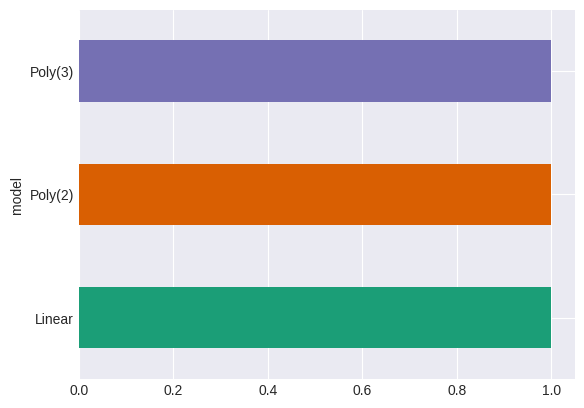

In [21]:
# @title model

from matplotlib import pyplot as plt
import seaborn as sns
metrics.groupby('model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)